In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  mean_squared_error,  mean_absolute_error
from scipy.stats import uniform, poisson
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import warnings
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Be logged into Google from SJU account
# Have dataset saved on SJU Gooogle Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import File
file_path = r'/content/drive/MyDrive/diabetic_data.csv'

# Load Dataset
diabetes_df = pd.read_csv(file_path)

In [ ]:
# Does dataset meet the requirements for this project?

num_features = diabetes_df.shape[1]
num_rows = diabetes_df.shape[0]

print(f"Number of features (columns): {num_features}")
print(f"Number of rows (data points): {num_rows}")

Number of features (columns): 50
Number of rows (data points): 101766




```
**Yes, number of features is over 25, rows greater than 10,000**
```



In [ ]:
# Clean Data;

# Look at values for each column
# Get unique values for each column:

for column in diabetes_df.columns:
    unique_values = diabetes_df[column].unique()
    print(f"Unique values for {column}:\n{unique_values}\n")

Unique values for encounter_id:
[  2278392    149190     64410 ... 443854148 443857166 443867222]

Unique values for patient_nbr:
[  8222157  55629189  86047875 ... 140199494 120975314 175429310]

Unique values for race:
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']

Unique values for gender:
['Female' 'Male' 'Unknown/Invalid']

Unique values for age:
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

Unique values for weight:
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']

Unique values for admission_type_id:
[6 1 2 3 4 5 8 7]

Unique values for discharge_disposition_id:
[25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]

Unique values for admission_source_id:
[ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]

Unique values for time_in_hospital:
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]

Unique values for payer_code:
['?' 'MC' 


Unique values for race, weight, medical_specialty, diag_2, diag_3, payer_code:   
    There is ‘?’ values that will need to be addressed

Unique values for gender:  'Unknown/Invalid' needs to be addressed

Rest of columns data looks good.

In [ ]:
# Check the number of times bad data appears in the dataset:

columns_to_check = ['race', 'gender', 'weight', 'medical_specialty', 'diag_2', 'diag_3', 'payer_code']

for column in columns_to_check:
    num_question_marks = (diabetes_df[column] == '?').sum()
    num_unknown_invalid = (diabetes_df[column] == 'Unknown/Invalid').sum()

    print(f"Number of '?' in {column}: {num_question_marks}")
    print(f"Number of 'Unknown/Invalid' in {column}: {num_unknown_invalid}\n")

Number of '?' in race: 2273
Number of 'Unknown/Invalid' in race: 0

Number of '?' in gender: 0
Number of 'Unknown/Invalid' in gender: 3

Number of '?' in weight: 98569
Number of 'Unknown/Invalid' in weight: 0

Number of '?' in medical_specialty: 49949
Number of 'Unknown/Invalid' in medical_specialty: 0

Number of '?' in diag_2: 358
Number of 'Unknown/Invalid' in diag_2: 0

Number of '?' in diag_3: 1423
Number of 'Unknown/Invalid' in diag_3: 0

Number of '?' in payer_code: 40256
Number of 'Unknown/Invalid' in payer_code: 0



'''
Need to consider what to do with WEIGHT category in our analysis, as there is missing data
in this category for 96.8% of the dataset

Need to consider what to do with MEDICAL SPECIALTY category, as there is missing data
in this category for 49.05% of the dataset.

Need to consider what to do with PAYER_CODE category, as there is missing data
in this category for 39.57% of the dataset.

The three categories above have large amounts of data missing.
Our options for these categories would be to:
    1. Impute missing values, could do this via mean, median, commmon specialty or
    Machine learning based imputation.  
        Thoughts:  I do not believe this would be wise given the amounts of data missing
    2. Create a new category, such as "Unknown" for missing amounts
        Thoughts:  I do not believe this is a viable solution since it is generic and will
        affect the dataset, especially if there is someone who weights 160 lbs vs.
        300 lbs.  Categorizing them as the same feels wrong.
    3. Drop the columns
        Thoughts:  Easy solution, not what I would want to do, especially for weight.
        Weight one would think is a very important category for a diabetes
        dataset.  

Given the three different options, will chose 3. Drop the columns.

The other columns showing missing data combine for 4,057 rows or 3.98% of
the dataset.  As this is not a significant amount of data, we will delete these
rows and not consider them in our analysis.

'''

In [ ]:
# Drop Weight, Medical Specialty and payer_code:

columns_to_drop = ['weight', 'medical_specialty', 'payer_code']
diabetes_df = diabetes_df.drop(columns=columns_to_drop)


# Remove rows with missing data:

# Replace '?' with NaN
diabetes_df.replace('?', np.nan, inplace=True)

# Replace 'Unknown/Invalid' with NaN
diabetes_df.replace('Unknown/Invalid', np.nan, inplace=True)

# Drop rows with missing values
diabetes_df = diabetes_df.dropna()


In [ ]:
# Look at data types:

column_data_types = diabetes_df.dtypes
print(column_data_types)

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide           

In [ ]:
print(diabetes_df)

        encounter_id  patient_nbr             race  gender      age  \
1             149190     55629189        Caucasian  Female  [10-20)   
2              64410     86047875  AfricanAmerican  Female  [20-30)   
3             500364     82442376        Caucasian    Male  [30-40)   
4              16680     42519267        Caucasian    Male  [40-50)   
5              35754     82637451        Caucasian    Male  [50-60)   
...              ...          ...              ...     ...      ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)   
101763     443854148     41088789        Caucasian    Male  [70-80)   
101764     443857166     31693671        Caucasian  Female  [80-90)   
101765     443867222    175429310        Caucasian    Male  [70-80)   

        admission_type_id  discharge_disposition_id  admission_source_id  \
1                       1                         1                    

In [ ]:
# Copy out to different dataframe for use later:
# For clustering:

cluster_df = diabetes_df.copy()

In [ ]:
# Descriptive Statistics

In [ ]:
# Count, Mean, std, min, max, percentile Data
diabetes_df.drop(['encounter_id', 'patient_nbr'], axis=1).describe()


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,2.025803,3.753396,5.776741,4.422011,43.148462,1.350712,16.119590,0.376382,0.202464,0.646871,7.512096
std,1.450121,5.309412,4.071632,2.993070,19.711757,1.708475,8.108496,1.283365,0.942897,1.271025,1.832472
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [ ]:
# Median Values
diabetes_df.drop(['encounter_id', 'patient_nbr'], axis=1).median()


<ipython-input-15-90faed29edec>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  diabetes_df.drop(['encounter_id', 'patient_nbr'], axis=1).median()


admission_type_id            1.0
discharge_disposition_id     1.0
admission_source_id          7.0
time_in_hospital             4.0
num_lab_procedures          44.0
num_procedures               1.0
num_medications             15.0
number_outpatient            0.0
number_emergency             0.0
number_inpatient             0.0
number_diagnoses             8.0
dtype: float64

In [ ]:
# Correlation Matrix

diabetes_df.drop(['encounter_id', 'patient_nbr'], axis=1).corr()


<ipython-input-16-d14b1ea6f602>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  diabetes_df.drop(['encounter_id', 'patient_nbr'], axis=1).corr()


,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
admission_type_id,1.000000,0.079882,0.109274,-0.012202,-0.141201,0.129457,0.080268,0.026128,-0.019798,-0.037116,-0.122592
discharge_disposition_id,0.079882,1.000000,0.016526,0.162903,0.022601,0.013879,0.106696,-0.010278,-0.025990,0.019037,0.038418
admission_source_id,0.109274,0.016526,1.000000,-0.007989,0.048039,-0.134654,-0.055733,0.025304,0.058999,0.035535,0.071749
time_in_hospital,-0.012202,0.162903,-0.007989,1.000000,0.318632,0.191164,0.464212,-0.010913,-0.010508,0.072282,0.211225
num_lab_procedures,-0.141201,0.022601,0.048039,0.318632,1.000000,0.058710,0.267863,-0.008625,-0.002142,0.039198,0.150257
num_procedures,0.129457,0.013879,-0.134654,0.191164,0.058710,1.000000,0.382952,-0.026453,-0.038723,-0.067535,0.058973
num_medications,0.080268,0.106696,-0.055733,0.464212,0.267863,0.382952,1.000000,0.042652,0.012127,0.062905,0.241501
number_outpatient,0.026128,-0.010278,0.025304,-0.010913,-0.008625,-0.026453,0.042652,1.000000,0.091033,0.105979,0.091414
number_emergency,-0.019798,-0.025990,0.058999,-0.010508,-0.002142,-0.038723,0.012127,0.091033,1.000000,0.267174,0.054616
number_inpatient,-0.037116,0.019037,0.035535,0.072282,0.039198,-0.067535,0.062905,0.105979,0.267174,1.000000,0.101244


In [ ]:
# P-Value data
# Selecting columns of interest
columns_of_interest = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
                         'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient',
                         'number_emergency', 'number_inpatient', 'number_diagnoses']

# Loop through pairs of columns and calculate correlation along with p-value
for col1 in columns_of_interest:
    for col2 in columns_of_interest:
        if col1 != col2:
            corr, p_value = pearsonr(diabetes_df[col1], diabetes_df[col2])
            print(f"Correlation between {col1} and {col2}: {corr}, p-value: {p_value}")


Correlation between admission_type_id and discharge_disposition_id: 0.07988217958680828, p-value: 1.6016896776730612e-138
Correlation between admission_type_id and admission_source_id: 0.10927404154412879, p-value: 3.9985976615327707e-258
Correlation between admission_type_id and time_in_hospital: -0.012201661338392508, p-value: 0.0001330027935163048
Correlation between admission_type_id and num_lab_procedures: -0.141201334130468, p-value: 0.0
Correlation between admission_type_id and num_procedures: 0.12945651957864363, p-value: 0.0
Correlation between admission_type_id and num_medications: 0.08026834323119333, p-value: 7.537860298078723e-140
Correlation between admission_type_id and number_outpatient: 0.026128057563905634, p-value: 2.7723557388857506e-16
Correlation between admission_type_id and number_emergency: -0.01979787780815424, p-value: 5.650309866426434e-10
Correlation between admission_type_id and number_inpatient: -0.03711552027032401, p-value: 3.0424323232204147e-31
Correl

Strong Positive Correlations:  time_in_hospital and num_medications have a strong positive correlation (0.464). It makes sense—more time in the hospital might lead to more medications.

Strong Negative Correlations:  admission_type_id and num_lab_procedures have a strong negative correlation (-0.141). It suggests a potential relationship where certain admission types may be associated with fewer lab procedures.

There are several weak to moderate correlations between various features, providing a nuanced view of potential associations.

In [ ]:
# Had an issue running ANOVA - as the code continuously timed out when running Tukeys
# Comparing categorical data with Heat Maps instead

<ipython-input-19-d79bc6d417e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data[categorical_column] = le.fit_transform(heatmap_data[categorical_column])


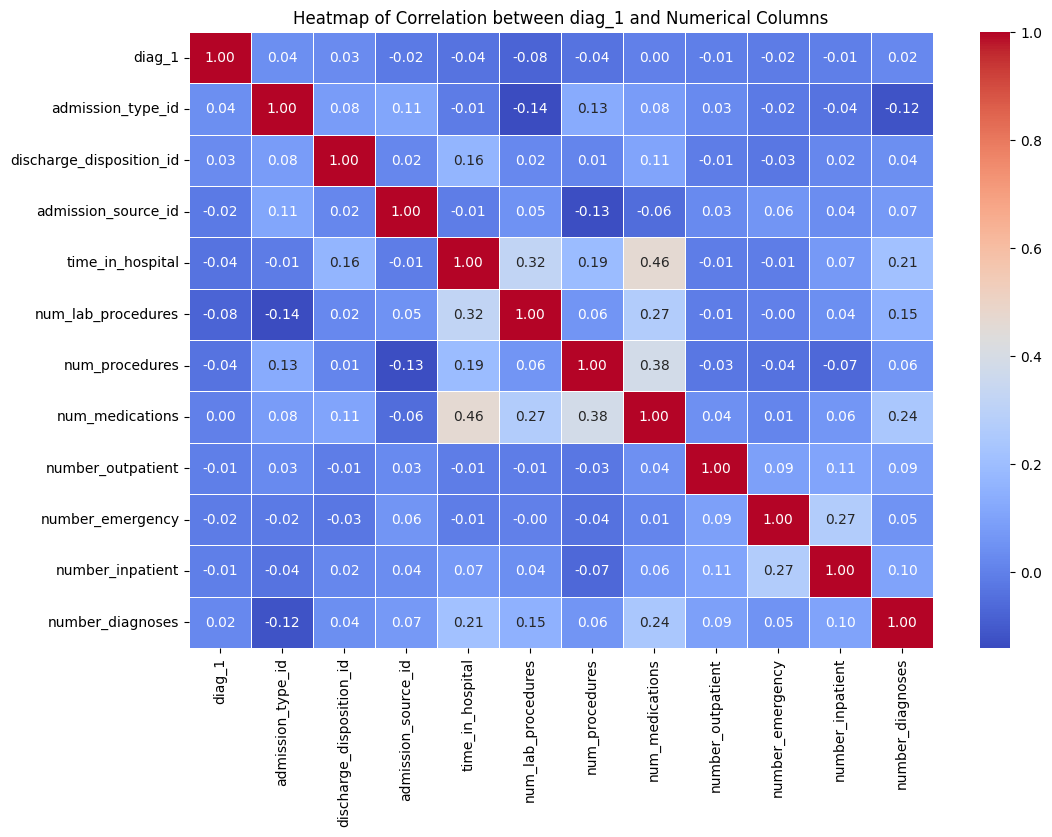

In [ ]:
# Choose the categorical column
categorical_column = 'diag_1'

# Select all numerical columns
numerical_columns = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
                     'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient',
                     'number_emergency', 'number_inpatient', 'number_diagnoses']

# Create a new DataFrame with only the selected columns
heatmap_data = diabetes_df[[categorical_column] + numerical_columns]

# Encode the categorical column for correlation calculation
le = LabelEncoder()
heatmap_data[categorical_column] = le.fit_transform(heatmap_data[categorical_column])

# Calculate the correlation matrix
correlation_matrix = heatmap_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Heatmap of Correlation between {categorical_column} and Numerical Columns')
plt.show()


<ipython-input-20-fc6ba785ee6f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_categorical_data['diag_1'] = le.fit_transform(heatmap_categorical_data['diag_1'])


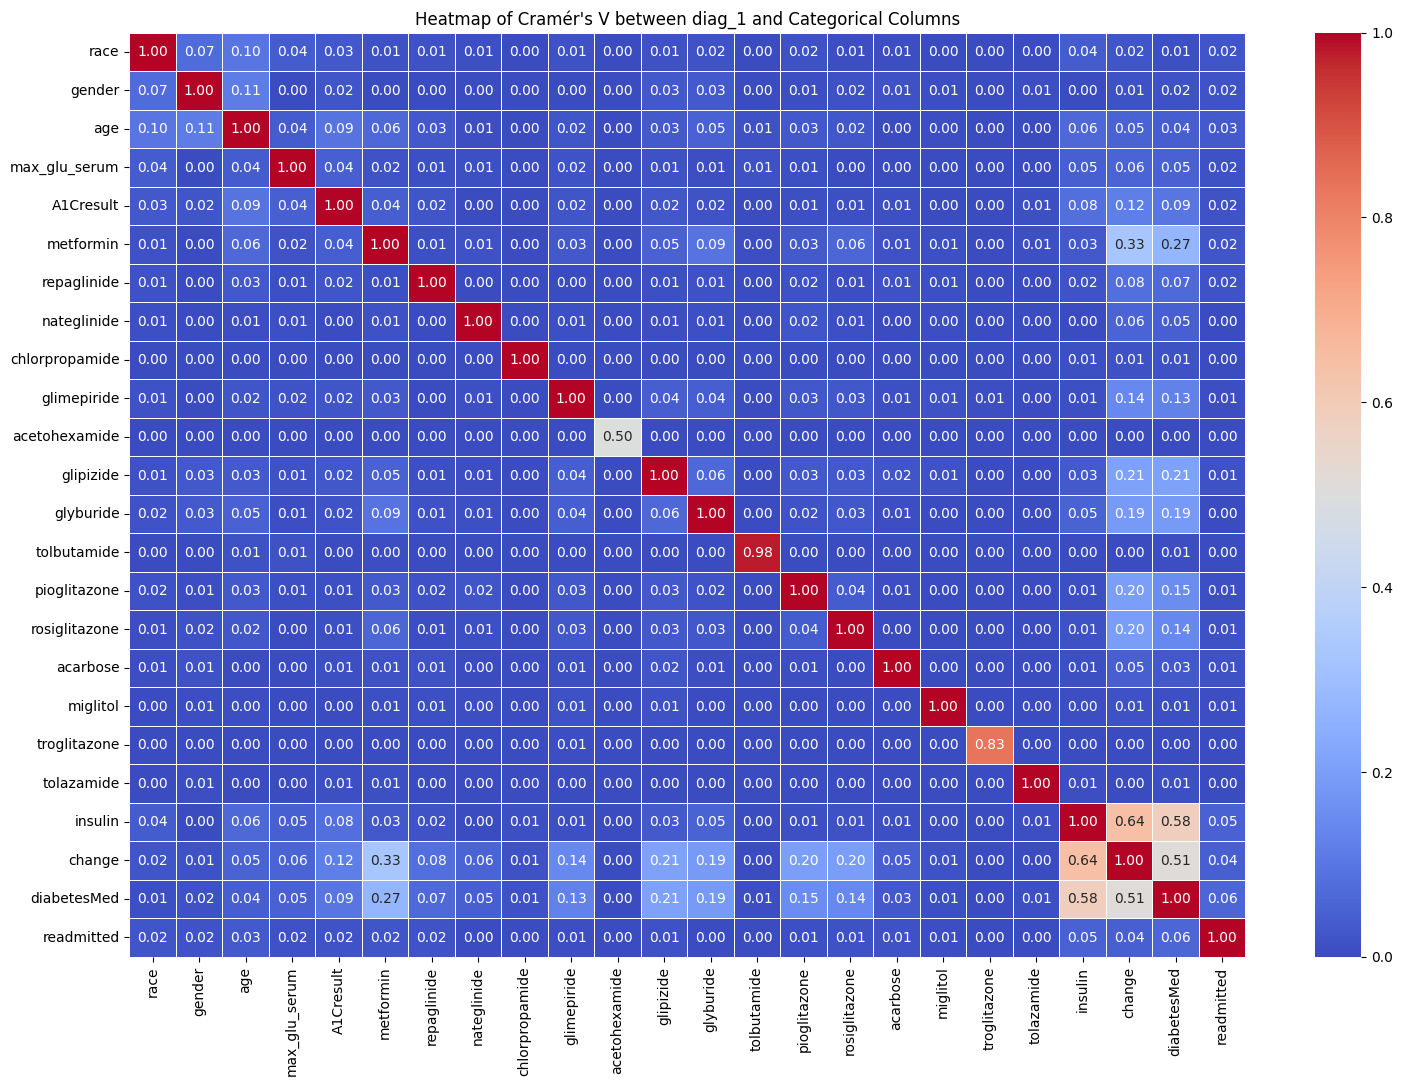

In [ ]:
# Heatmap #2
# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Label Encoder for encoding categorical variables
le = LabelEncoder()

# Select all categorical columns that exist in the DataFrame
categorical_columns = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
                        'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
                        'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
                        'troglitazone', 'tolazamide', 'insulin', 'change', 'diabetesMed', 'readmitted']

# Create a new DataFrame with 'diag_1' and selected categorical columns
heatmap_categorical_data = diabetes_df[['diag_1'] + categorical_columns]

# Encode the 'diag_1' column for correlation calculation
heatmap_categorical_data['diag_1'] = le.fit_transform(heatmap_categorical_data['diag_1'])

# Calculate Cramér's V for each pair of categorical variables
cramer_v_matrix = np.zeros((len(categorical_columns), len(categorical_columns)))
for i in range(len(categorical_columns)):
    for j in range(len(categorical_columns)):
        confusion_matrix = pd.crosstab(heatmap_categorical_data[categorical_columns[i]], heatmap_categorical_data[categorical_columns[j]]).values
        cramer_v_matrix[i, j] = cramers_v(confusion_matrix)

# Create a DataFrame for the heatmap
cramer_v_df = pd.DataFrame(cramer_v_matrix, index=categorical_columns, columns=categorical_columns)

# Plot the heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(cramer_v_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Cramér\'s V between diag_1 and Categorical Columns')
plt.show()


Findings from Heat Map:


In [ ]:
# Ariel will Present everything above

In [ ]:
# Sandhya with Decision Trees:

In [ ]:
# Decision Tress

# Create Seperate DF
tree_df = diabetes_df.copy()

In [ ]:
# Create label mappings for all categorical columns
# I want to be able to look up the original values
# After creating binary mappings
# gonna do this via a function

categorical_columns = ['race', 'gender',
                       'age', 'diag_1','diag_2', 'diag_3','max_glu_serum',
                       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                       'miglitol', 'troglitazone', 'tolazamide', 'examide',
                       'citoglipton', 'insulin', 'glyburide-metformin',
                       'glipizide-metformin', 'glimepiride-pioglitazone',
                       'metformin-rosiglitazone', 'metformin-pioglitazone',
                       'change', 'diabetesMed', 'readmitted']

def apply_label_mappings(df, categorical_columns):
    label_mappings = {}


    for column in categorical_columns:
        unique_values = df[column].unique()
        label_mapping = {value: i+1 for i, value in enumerate(unique_values)}
        label_mappings[column] = label_mapping
        df[column] = df[column].map(label_mapping)

    # Display the mappings for reference
    for column, mapping in label_mappings.items():
        print(f"{column} Label Mapping:", mapping)

# Call the function with tree_df
apply_label_mappings(tree_df, categorical_columns)

race Label Mapping: {'Caucasian': 1, 'AfricanAmerican': 2, 'Other': 3, 'Asian': 4, 'Hispanic': 5}
gender Label Mapping: {'Female': 1, 'Male': 2}
age Label Mapping: {'[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9, '[0-10)': 10}
diag_1 Label Mapping: {'276': 1, '648': 2, '8': 3, '197': 4, '414': 5, '428': 6, '398': 7, '434': 8, '250.7': 9, '157': 10, '518': 11, '999': 12, '410': 13, '682': 14, '402': 15, 'V57': 16, '189': 17, '786': 18, '427': 19, '996': 20, '277': 21, '584': 22, '462': 23, '473': 24, '411': 25, '174': 26, '486': 27, '998': 28, '511': 29, '432': 30, '626': 31, '295': 32, '196': 33, '250.6': 34, '182': 35, '845': 36, '423': 37, '808': 38, '250.4': 39, '722': 40, '403': 41, '784': 42, '707': 43, '440': 44, '151': 45, '715': 46, '997': 47, '198': 48, '564': 49, '38': 50, '590': 51, '578': 52, '250.32': 53, '433': 54, '569': 55, '185': 56, '536': 57, '255': 58, '250.13': 59, '599': 60, '558': 61, 

In [ ]:
print(tree_df.dtypes)
tree_df.shape

encounter_id                int64
patient_nbr                 int64
race                        int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
diag_1                      int64
diag_2                      int64
diag_3                      int64
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
acetohexamide               int64
glipizide                   int64
glyburide                   int64
tolbutamide   

(98052, 47)

In [ ]:
# Drop 'encounter_id' and 'patient_nbr' columns
tree_df = tree_df.drop(['encounter_id', 'patient_nbr'], axis=1)

In [ ]:
tree_df.shape


(98052, 45)

In [ ]:
#Assigning Dependent and Independent variables
X_Tree = tree_df.drop('readmitted', axis=1)
y_Tree = tree_df['readmitted']

In [ ]:
#Split the dataset into training and testing sets
X_Tree_train, X_Tree_test, y_Tree_train, y_Tree_test = train_test_split(X_Tree, y_Tree, test_size=0.2, random_state=42)

In [ ]:
# Create a Decision Tree model
Tree_model = DecisionTreeClassifier( random_state=42)

In [ ]:
# Train the model
Tree_model.fit(X_Tree_train, y_Tree_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Make predictions on the test set
Tree_predictions = Tree_model.predict(X_Tree_test)

# Evaluate the model
Tree_accuracy = accuracy_score(y_Tree_test, Tree_predictions)
Tree_report = classification_report(y_Tree_test, Tree_predictions)

# Print the results
print(f'Test Accuracy: {Tree_accuracy:.2f}')
print('\nClassification Report:\n', Tree_report)

Test Accuracy: 0.47

Classification Report:
               precision    recall  f1-score   support

           1       0.40      0.40      0.40      6940
           2       0.59      0.58      0.59     10548
           3       0.15      0.16      0.15      2123

    accuracy                           0.47     19611
   macro avg       0.38      0.38      0.38     19611
weighted avg       0.48      0.47      0.48     19611



In [ ]:
#Evaluate the model's accuracy on the training set using the same metrics as in the classification report.
Tree_train_predictions = Tree_model.predict(X_Tree_train)
Tree_train_accuracy = accuracy_score(y_Tree_train, Tree_train_predictions)

print(f'Train Accuracy: {Tree_train_accuracy:.2f}')

Train Accuracy: 1.00


**The large gap between training and test accuracy is a strong indicator of overfitting.**
**Before coming to conclusion, let do a cross validation score check to ensure the overfitting.**

In [ ]:
Tree_cv_scores = cross_val_score(Tree_model, X_Tree, y_Tree, cv=5)
print(f'Cross-Validation Scores: {Tree_cv_scores}')
print(f'Mean CV Accuracy: {Tree_cv_scores.mean():.2f}')

Cross-Validation Scores: [0.45443884 0.4689205  0.46369199 0.45813361 0.45762366]
Mean CV Accuracy: 0.46


1.The cross-validation scores provide an estimate of your model's performance on
different subsets of the data.
2.The mean accuracy of around 0.46 suggests that, on average, the model predicts the correct class for approximately 46% of the instances in the dataset.

**Overfitting:**
The cross-validation scores are in line with the test accuracy you reported earlier (Test Accuracy: 0.47). This consistency suggests that the model is not drastically overfitting to the training data.

**Room for Improvement:**
The accuracy is still relatively low, indicating that there is room for improvement in the model's predictive performance.

AS accuracy is the primary metric of interest, exploring additional **feature engineering, hyperparameter tuning** would help us in predicting the model better

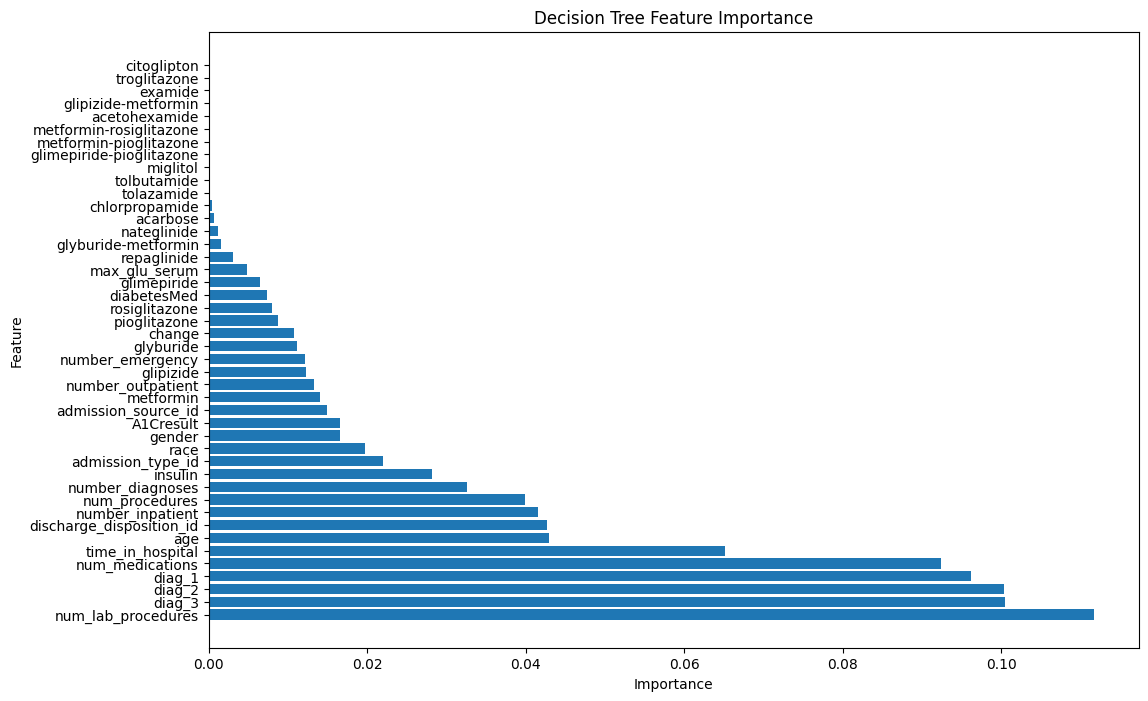

                     Feature  Importance
7         num_lab_procedures    0.111716
15                    diag_3    0.100476
14                    diag_2    0.100334
13                    diag_1    0.096137
9            num_medications    0.092379
6           time_in_hospital    0.065093
2                        age    0.042983
4   discharge_disposition_id    0.042621
12          number_inpatient    0.041540
8             num_procedures    0.039914
16          number_diagnoses    0.032641
36                   insulin    0.028118
3          admission_type_id    0.021977
0                       race    0.019722
1                     gender    0.016566
18                 A1Cresult    0.016508
5        admission_source_id    0.014967
19                 metformin    0.014033
10         number_outpatient    0.013271
25                 glipizide    0.012329
11          number_emergency    0.012166
26                 glyburide    0.011163
42                    change    0.010737
28              

In [ ]:
# Extract feature importance from the model
feature_importance = Tree_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X_Tree.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending= False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importance')
plt.show()

# Display the sorted feature importance DataFrame
print(feature_importance_df)



The **feature importance** values represent the contribution of each feature to the decision-making process of the decision tree model. **Higher importance values** indicate that the **feature is more influential in making predictions**.

**Features with zero importance** (0.000000) might not contribute at all to the decision-making process. These can potentially be candidates for **removal**.

Hence dropping glimepiride-pioglitazone,metformin-pioglitazone,metformin-rosiglitazone, acetohexamide, glipizide-metformin, examide, troglitazone, citoglipton to make the model simple and see if there is any improvemnt with accuracy



In [ ]:
# Drop features with zero importance
tree_df = tree_df.drop(['glimepiride-pioglitazone', 'metformin-pioglitazone','metformin-rosiglitazone', 'acetohexamide','glipizide-metformin', 'examide','troglitazone', 'citoglipton'], axis=1)

In [ ]:
# Drop features have values close to zero importance
tree_df = tree_df.drop(['tolbutamide', 'miglitol'], axis=1)

In [ ]:
tree_df.shape

(98052, 35)

In [ ]:
#Assigning Dependent and Independent variables
X_Tree = tree_df.drop('readmitted', axis=1)
y_Tree = tree_df['readmitted']
#Split the dataset into training and testing sets
X_Tree_train, X_Tree_test, y_Tree_train, y_Tree_test = train_test_split(X_Tree, y_Tree, test_size=0.2, random_state=42)

# Create a Decision Tree model
Tree_model = DecisionTreeClassifier( random_state=42)
# Train the model
Tree_model.fit(X_Tree_train, y_Tree_train)
# Make predictions on the test set
Tree_predictions = Tree_model.predict(X_Tree_test)

# Evaluate the model
Tree_accuracy = accuracy_score(y_Tree_test, Tree_predictions)
Tree_report = classification_report(y_Tree_test, Tree_predictions)

# Print the results
print(f'Test Accuracy: {Tree_accuracy:.2f}')
print('\nClassification Report:\n', Tree_report)

#Evaluate the model's accuracy on the training set using the same metrics as in the classification report.
Tree_train_predictions = Tree_model.predict(X_Tree_train)
Tree_train_accuracy = accuracy_score(y_Tree_train, Tree_train_predictions)

print(f'Train Accuracy: {Tree_train_accuracy:.2f}')




Test Accuracy: 0.47

Classification Report:
               precision    recall  f1-score   support

           1       0.40      0.40      0.40      6940
           2       0.60      0.58      0.59     10548
           3       0.15      0.17      0.16      2123

    accuracy                           0.47     19611
   macro avg       0.38      0.38      0.38     19611
weighted avg       0.48      0.47      0.48     19611

Train Accuracy: 1.00


In [ ]:
Tree_cv_scores = cross_val_score(Tree_model, X_Tree, y_Tree, cv=5)
print(f'Cross-Validation Scores: {Tree_cv_scores}')
print(f'Mean CV Accuracy: {Tree_cv_scores.mean():.2f}')

Cross-Validation Scores: [0.45709041 0.46999133 0.46573177 0.45747068 0.4599694 ]
Mean CV Accuracy: 0.46


Accuray score hasnt changed much and Mean CV Accuracy is same as before

**Tuning the hyperparamater in decision tree to see if there is any improvement with the model.**
**Trying two of the most popular approaches for hyperparameter tuning- Grid Search and Randomised Search.**

In [ ]:
############################## GRID SEARCH ##########################################

# setup parameter space
parameters = {'criterion':['gini','entropy'],
              'max_depth':np.arange(3,11),
              'min_samples_split':np.arange(2,6),
              'max_leaf_nodes':np.arange(5,16)}

# create an instance of the grid search object
g1 = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()
g1.fit(X_Tree_train,y_Tree_train)
duration = time.time() - start_time

# show best parameter configuration found for classifier
cls_params1 = g1.best_params_
cls_params1

{'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 15,
 'min_samples_split': 2}

In [ ]:
# compute performance on test set
# Micro average option is set give equal weight to each instance, irrespective of its class

model = g1.best_estimator_
y_pred = model.predict(X_Tree_test)
precision = precision_score(y_Tree_test,y_pred, average= 'micro')
recall = recall_score(y_Tree_test,y_pred, average= 'micro')
f1Score = f1_score(y_Tree_test,y_pred, average= 'micro')
print('GRID SEARCH PERFORMANCE SCORE')
print('accuracy score: %.2f' % accuracy_score(y_Tree_test,y_pred))
print('precision score: %.2f' % precision)
print('recall score: %.2f' % recall )
print('f1 score: %.2f' % f1Score)
print('computation time: %.2f' % duration)

GRID SEARCH PERFORMANCE SCORE
accuracy score: 0.57
precision score: 0.57
recall score: 0.57
f1 score: 0.57
computation time: 627.95


**All the metrics being the same (accuracy, precision, recall, and F1 score all equal to 0.57) suggests that the model is consistently**
**predicting one class, and this class likely represents the majority of the instances in test set(imbalance).**

**Hence using weighted average option to account for class imbalance in metrics calculation**

In [ ]:
# compute performance on test set using weighted average to account for class imbalance
model = g1.best_estimator_
y_pred = model.predict(X_Tree_test)
precision = precision_score(y_Tree_test,y_pred, average= 'weighted', zero_division=1)
recall = recall_score(y_Tree_test,y_pred, average= 'weighted', zero_division=1)
f1Score = f1_score(y_Tree_test,y_pred, average= 'weighted', zero_division=1)
print('accuracy score: %.2f' % accuracy_score(y_Tree_test,y_pred))
print('precision score: %.2f' % precision)
print('recall score: %.2f' % recall )
print('f1 score: %.2f' % f1Score)
print('computation time: %.2f' % duration)

accuracy score: 0.57
precision score: 0.60
recall score: 0.57
f1 score: 0.52
computation time: 627.95


Accuracy measures the overall correctness of the model's predictions. In this case, an accuracy of 0.57 (57%) indicates that the model is correctly predicting the target variable for approximately 58% of the instances in the test set.

Precision of 0.60 (60%) suggests that, among the instances predicted as positive by the model, approximately 60% are true positives.

Recall (Sensitivity or True Positive Rate) measures the ratio of true positive predictions to the total actual positives. A recall score of 0.57 (57%) indicates that the model is capturing approximately 57% of the actual positive instances.

The F1 score is the harmonic mean of precision and recall. It provides a balance between precision and recall. Your F1 score of 0.52 (52%) suggests a reasonable trade-off between precision and recall

In [ ]:
report = classification_report(y_Tree_test, y_pred, zero_division=1)
print('\nClassification Report of GRID search:\n', report)


Classification Report of GRID search:
               precision    recall  f1-score   support

           1       0.49      0.34      0.40      6940
           2       0.60      0.84      0.70     10548
           3       1.00      0.00      0.00      2123

    accuracy                           0.57     19611
   macro avg       0.70      0.39      0.37     19611
weighted avg       0.60      0.57      0.52     19611



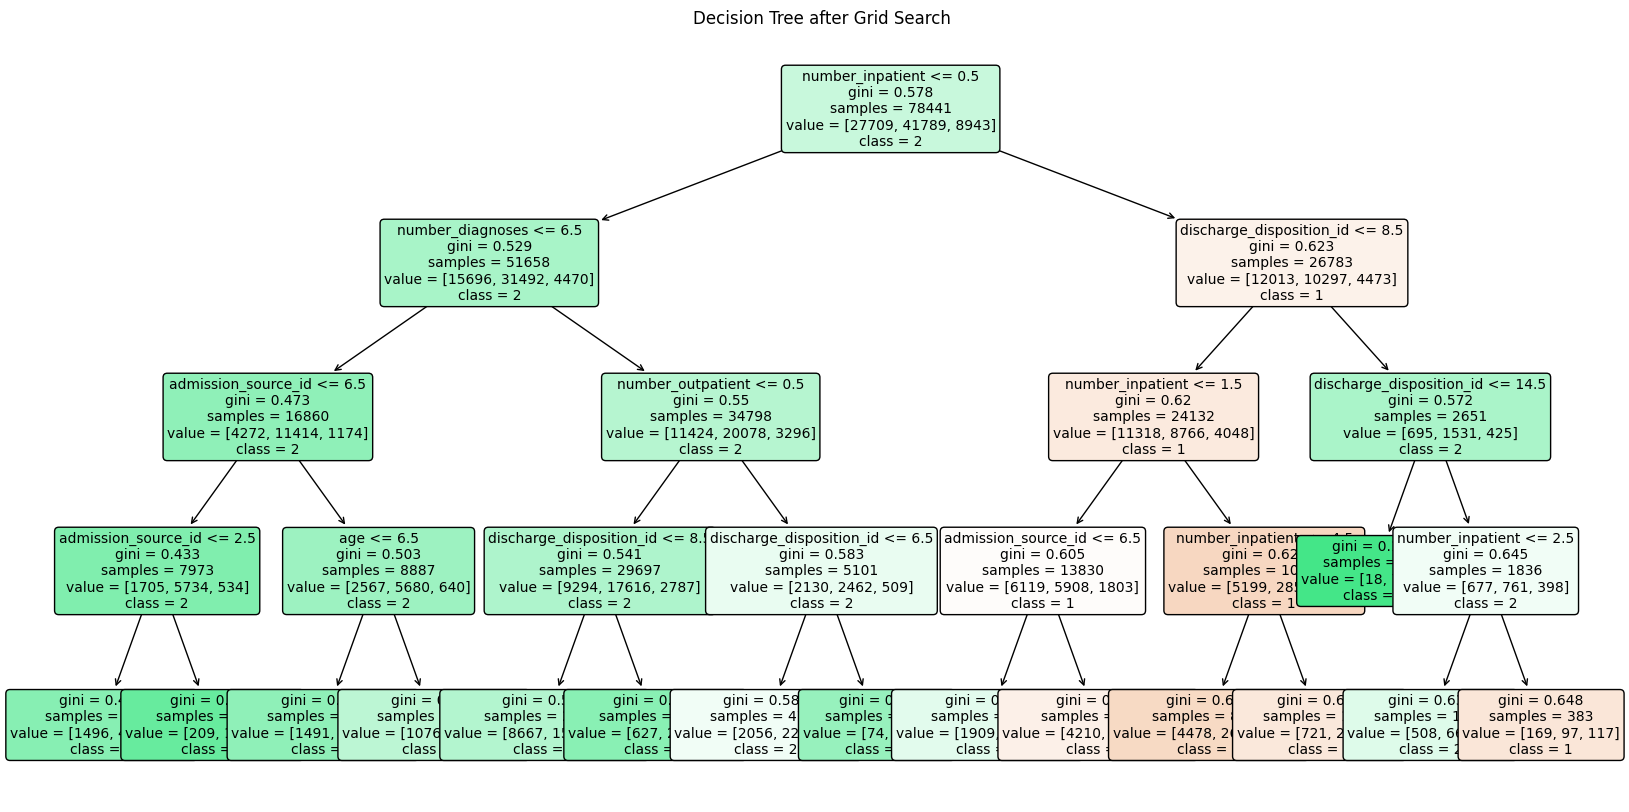

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(g1.best_estimator_, feature_names=X_Tree.columns, class_names=['1','2','3'], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree after Grid Search")
plt.show()

In [ ]:
####################################### Randomised Search #####################################################
# setup parameter space
parameters = {'criterion':['gini','entropy'],'max_depth':poisson(mu=2,loc=2),'min_samples_split':uniform(),'max_leaf_nodes':poisson(mu=4,loc=3)}

# create an instance of the randomized search object
r1 = RandomizedSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_iter=100, random_state=42, n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()
r1.fit(X_Tree_train,y_Tree_train)
duration = time.time() - start_time

# show best parameter configuration found for classifier
cls_params2 = r1.best_params_
cls_params2['min_samples_split'] = np.ceil(cls_params2['min_samples_split']*X_Tree_train.shape[0])
cls_params2

{'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 11,
 'min_samples_split': 2069.0}

In [ ]:
# compute performance on test set
model = r1.best_estimator_
y_pred = model.predict(X_Tree_test)
precision = precision_score(y_Tree_test,y_pred, average= 'weighted', zero_division=1)
recall = recall_score(y_Tree_test,y_pred, average= 'weighted', zero_division=1)
f1Score = f1_score(y_Tree_test,y_pred, average= 'weighted', zero_division=1)
print('accuracy score: %.2f' % accuracy_score(y_Tree_test,y_pred))
print('precision score: %.2f' % precision)
print('recall score: %.2f' % recall)
print('f1 score: %.2f' % f1Score)
print('computation time: %.2f' % duration)

accuracy score: 0.56
precision score: 0.60
recall score: 0.56
f1 score: 0.52
computation time: 57.44


In [ ]:
report = classification_report(y_Tree_test, y_pred, zero_division=1)
print('\nClassification Report Randomised Search:\n', report)


Classification Report Randomised Search:
               precision    recall  f1-score   support

           1       0.46      0.39      0.43      6940
           2       0.61      0.79      0.69     10548
           3       1.00      0.00      0.00      2123

    accuracy                           0.56     19611
   macro avg       0.69      0.39      0.37     19611
weighted avg       0.60      0.56      0.52     19611



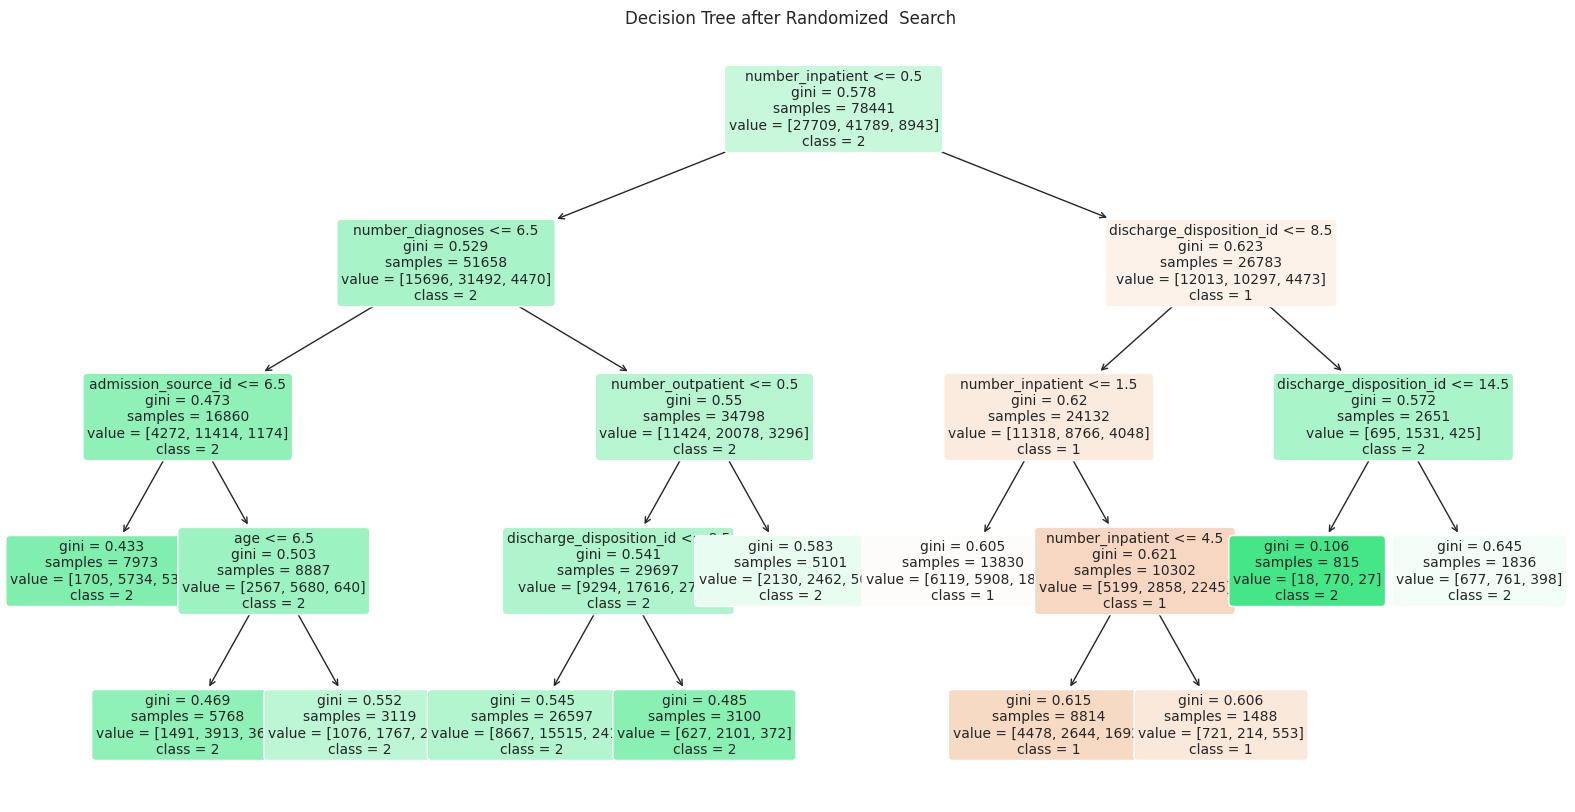

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(r1.best_estimator_, feature_names=X_Tree.columns, class_names=['1','2','3'], filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree after Randomized  Search")
plt.show()

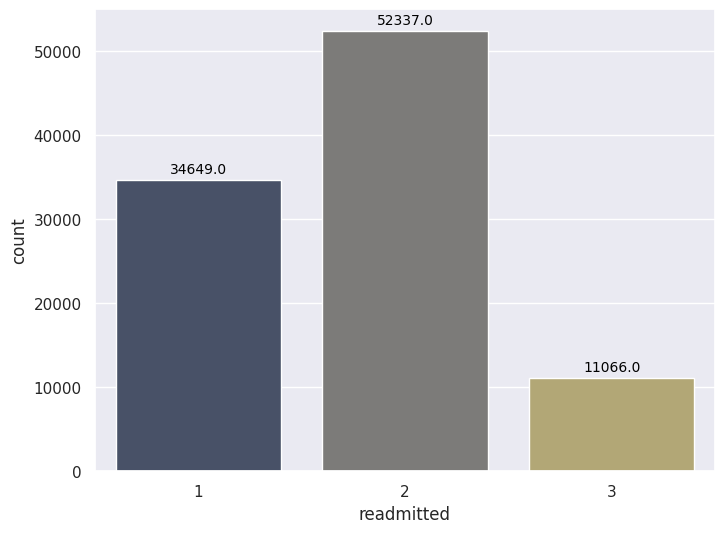

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))

# Create countplot
ax = sns.countplot(x="readmitted", data=tree_df, palette="cividis")

# Add count values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Show the plot
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_Tree, y_Tree, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
resampled_counts = pd.Series(y_resampled)
print(resampled_counts.value_counts())

# Create a Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model on the resampled data
model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f'Test Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', report)


1    41789
2    41789
3    41789
Name: readmitted, dtype: int64
Test Accuracy: 0.45

Classification Report:
               precision    recall  f1-score   support

           1       0.40      0.40      0.40      6940
           2       0.59      0.54      0.57     10548
           3       0.14      0.19      0.16      2123

    accuracy                           0.45     19611
   macro avg       0.38      0.38      0.38     19611
weighted avg       0.47      0.45      0.46     19611




It looks like oversampling with SMOTE has improved the balance in your classes, but the overall model performance (accuracy, precision, recall, and F1-score) hasn't improved significantly

In [ ]:
# Create a Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model on the resampled data
model.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f'Test Accuracy: {accuracy:.2f}')
print('\nClassification Report:\n', report)

Test Accuracy: 0.55

Classification Report:
               precision    recall  f1-score   support

           1       0.46      0.41      0.43      6940
           2       0.62      0.73      0.67     10548
           3       0.21      0.09      0.12      2123

    accuracy                           0.55     19611
   macro avg       0.43      0.41      0.41     19611
weighted avg       0.52      0.55      0.53     19611



In [ ]:
# John M's Part

In [ ]:
# Clustering (John O's Part)

# Next step is to decide if it should be Binary Encoding or One-Hot Encoding
# for the categorical data.
# Do to the size, I will use Binary, as creating seperate columns for each data point
# will be time consumming and not efficient for memory and computation

In [ ]:
# Create label mappings for all categorical columns
# I want to be able to look up the original values
# After creating binary mappings
# gonna do this via a function

categorical_columns = ['race', 'gender',
                       'age', 'diag_1','diag_2', 'diag_3','max_glu_serum',
                       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                       'miglitol', 'troglitazone', 'tolazamide', 'examide',
                       'citoglipton', 'insulin', 'glyburide-metformin',
                       'glipizide-metformin', 'glimepiride-pioglitazone',
                       'metformin-rosiglitazone', 'metformin-pioglitazone',
                       'change', 'diabetesMed', 'readmitted']

def apply_label_mappings(df, categorical_columns):
    label_mappings = {}


    for column in categorical_columns:
        unique_values = df[column].unique()
        label_mapping = {value: i+1 for i, value in enumerate(unique_values)}
        label_mappings[column] = label_mapping
        df[column] = df[column].map(label_mapping)

    # Display the mappings for reference
    for column, mapping in label_mappings.items():
        print(f"{column} Label Mapping:", mapping)

# Call the function with cluster_df
apply_label_mappings(cluster_df, categorical_columns)

race Label Mapping: {'Caucasian': 1, 'AfricanAmerican': 2, 'Other': 3, 'Asian': 4, 'Hispanic': 5}
gender Label Mapping: {'Female': 1, 'Male': 2}
age Label Mapping: {'[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9, '[0-10)': 10}
diag_1 Label Mapping: {'276': 1, '648': 2, '8': 3, '197': 4, '414': 5, '428': 6, '398': 7, '434': 8, '250.7': 9, '157': 10, '518': 11, '999': 12, '410': 13, '682': 14, '402': 15, 'V57': 16, '189': 17, '786': 18, '427': 19, '996': 20, '277': 21, '584': 22, '462': 23, '473': 24, '411': 25, '174': 26, '486': 27, '998': 28, '511': 29, '432': 30, '626': 31, '295': 32, '196': 33, '250.6': 34, '182': 35, '845': 36, '423': 37, '808': 38, '250.4': 39, '722': 40, '403': 41, '784': 42, '707': 43, '440': 44, '151': 45, '715': 46, '997': 47, '198': 48, '564': 49, '38': 50, '590': 51, '578': 52, '250.32': 53, '433': 54, '569': 55, '185': 56, '536': 57, '255': 58, '250.13': 59, '599': 60, '558': 61, 

In [ ]:
# check changes:

print(cluster_df)

        encounter_id  patient_nbr  race  gender  age  admission_type_id  \
1             149190     55629189     1       1    1                  1   
2              64410     86047875     2       1    2                  1   
3             500364     82442376     1       2    3                  1   
4              16680     42519267     1       2    4                  1   
5              35754     82637451     1       2    5                  2   
...              ...          ...   ...     ...  ...                ...   
101761     443847548    100162476     2       2    7                  1   
101762     443847782     74694222     2       1    8                  1   
101763     443854148     41088789     1       2    7                  1   
101764     443857166     31693671     1       1    8                  2   
101765     443867222    175429310     1       2    7                  1   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
1                       

In [ ]:
# dropping encounter id and patient nbr as they have no relevance

# Drop 'encounter_id' and 'patient_nbr' columns
cluster_df = cluster_df.drop(['encounter_id', 'patient_nbr'], axis=1)

In [ ]:
# check changes 2:  unnique values:

for column in cluster_df.columns:
    unique_values = cluster_df[column].unique()
    print(f"Unique values in {column}:", unique_values)

Unique values in encounter_id: [   149190     64410    500364 ... 443854148 443857166 443867222]
Unique values in patient_nbr: [ 55629189  86047875  82442376 ... 140199494 120975314 175429310]
Unique values in race: [1 2 3 4 5]
Unique values in gender: [1 2]
Unique values in age: [ 1  2  3  4  5  6  7  8  9 10]
Unique values in admission_type_id: [1 2 3 6 4 5 8 7]
Unique values in discharge_disposition_id: [ 1  3  6  2  5 11  7 25 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
Unique values in admission_source_id: [ 7  2  4  1  5  6 20  3 17  8  9 14 10 22 11 25 13]
Unique values in time_in_hospital: [ 3  2  1  4  5 13 12  9  7 10 11  6  8 14]
Unique values in num_lab_procedures: [ 59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29  35
  42  19  64  25  53  52  87  27  37  46  41  28  36  48  72  10   2  65
  67  40  58  57  32  83  34  39  69  38  56  22  96  78  61  88  66  43
  50   1  18  82  54   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  

In [ ]:
# Changes look good to cluster_df

In [ ]:
# Scale cluster_df, prevent larger scales from dominating the analysis

scaler = MinMaxScaler()
cluster_df_scaled = pd.DataFrame(scaler.fit_transform(cluster_df), columns=cluster_df.columns)

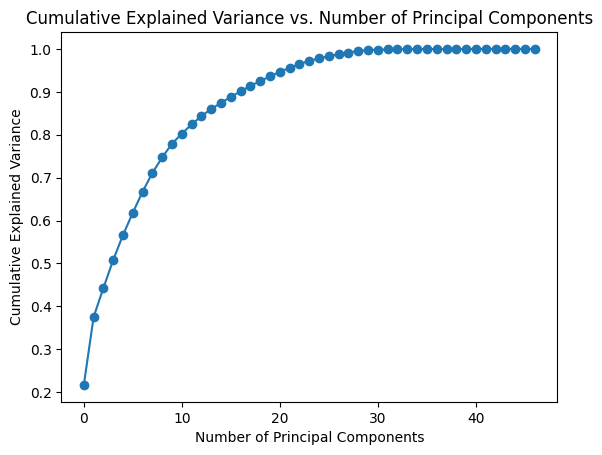

In [ ]:
# Use PCA
#  scaled data and k-means clustering

# Apply PCA to scaled data
pca = PCA()
pca_result = pca.fit_transform(cluster_df_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the Cumulative Explained Variance
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()

In [ ]:
# Suppress DBSCAN warning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


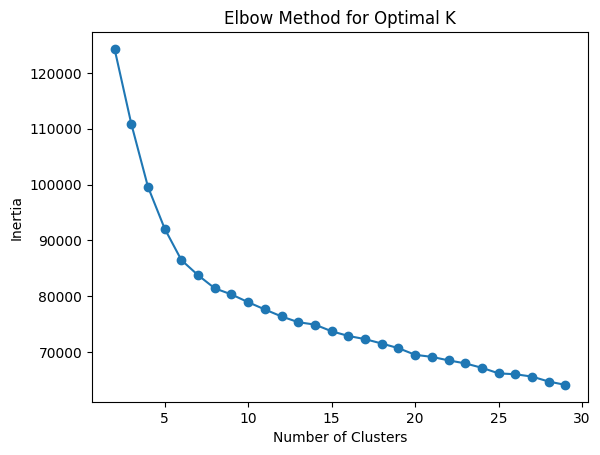

In [ ]:
# Initialize the range of clusters to try
num_clusters = range(2, 30)

# Initialize list to store the inertia (within-cluster sum of squares) for each cluster
inertia_values = []

# Fit K-Means for different numbers of clusters and record inertia
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(pca_result)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(num_clusters, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [ ]:
# By viewing the Elbow method, the number of clusters
# Should be between 4 and 9:

# Initialize the range of clusters to try
num_clusters = range(4, 9)

# Initialize list to store silhouette scores for each cluster
silhouette_scores = []

# Fit K-Means for different numbers of clusters and record silhouette scores
for n in num_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_result)
    silhouette_scores.append(silhouette_score(pca_result, cluster_labels))

# Find the best number of clusters based on silhouette score
best_num_clusters = num_clusters[np.argmax(silhouette_scores)]
best_silhouette_score = max(silhouette_scores)



print(f"Best Number of Clusters: {best_num_clusters}")
print(f"Best Silhouette Score: {best_silhouette_score}")

Best Number of Clusters: 6
Best Silhouette Score: 0.20300281970977263


In [ ]:
''' For K-means, 6 has the best number of clusters'''

In [ ]:
# Get top 10 features from each PCA
pca = PCA()
pca_result = pca.fit_transform(cluster_df_scaled)

# Display the top 10 principal components and their corresponding features
top_10_components = pca.components_[:10, :]
top_10_feature_names = cluster_df_scaled.columns

for i in range(10):
    print(f"\nPrincipal Component {i + 1}:\n")
    component_values = top_10_components[i]
    sorted_indices = np.argsort(np.abs(component_values))[::-1]

    for j in range(10):
        feature_index = sorted_indices[j]
        feature_name = top_10_feature_names[feature_index]
        print(f"{feature_name}: {component_values[feature_index]}")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Fit K-Means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=6, random_state=42)
final_cluster_labels = final_kmeans.fit_predict(pca_result)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in range(6):
    cluster_points = pca_result[final_cluster_labels == cluster_label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {cluster_label + 1}')

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D K Means Clustering Visualization')

# Add legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Fit K-Means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=6, random_state=42)
final_kmeans.fit(pca_result)

# Create a DataFrame with centroids
centroids_df = pd.DataFrame(final_kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Display the centroids
print("Centroids for each cluster:")
print(centroids_df)

In [ ]:
# Fit K-Means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=6, random_state=42)
final_cluster_labels = final_kmeans.fit_predict(pca_result)

# Create a DataFrame with cluster labels
cluster_df['Cluster'] = final_cluster_labels

# Inverse transform the centroids to the original space
original_centroids = scaler.inverse_transform(pca.inverse_transform(final_kmeans.cluster_centers_))

# Create a DataFrame with the original variable averages for each cluster
original_centroids_df = pd.DataFrame(original_centroids, columns=cluster_df.columns[:-1])  # Exclude the 'Cluster' column

# Display the original variable averages for each cluster
print("Original variable averages for each cluster:")
print(original_centroids_df)

In [ ]:
# Fit K-Means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=6, random_state=42)
final_cluster_labels = final_kmeans.fit_predict(pca_result)

# Create a DataFrame with cluster labels
cluster_df['Cluster'] = final_cluster_labels

# Inverse transform the centroids to the original space
original_centroids = scaler.inverse_transform(pca.inverse_transform(final_kmeans.cluster_centers_))

# Create a DataFrame with the original variable averages for each cluster
original_centroids_df = pd.DataFrame(original_centroids, columns=cluster_df.columns[:-1])  # Exclude the 'Cluster' column

# Display the original variable averages for each cluster
print("Original variable averages for each cluster:")
print(original_centroids_df)

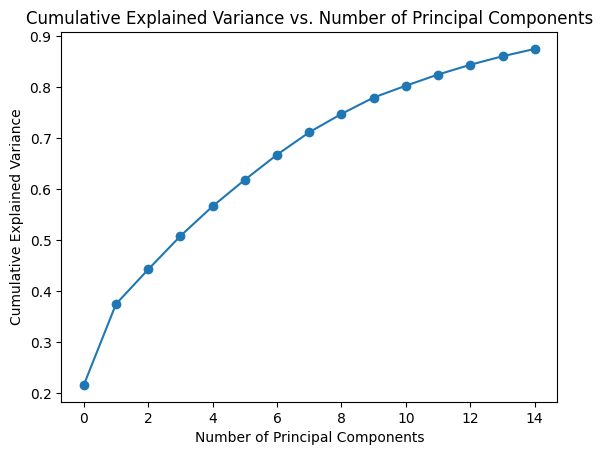

In [ ]:
# Agglomerative
# need to reduce PCA components first, due to memory issues:

# Apply PCA with 15 components
pca = PCA(n_components=15)
pca_result = pca.fit_transform(cluster_df_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the Cumulative Explained Variance
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.show()


In [ ]:
'''I tried Agglomerative, however I kept getting memory issues whenever I ran it.
    The attempted code is in this block.


Error:  MemoryError: Unable to allocate 35.8 GiB for an array with shape (4807048326,) and data type float64
# Agglomerative

# Initialize the range of clusters to try
num_clusters = range(2, 3)

# Initialize list to store silhouette scores for each cluster
agglomerative_silhouette_scores = []

# Fit Agglomerative Clustering for different numbers of clusters and record silhouette scores
for n in num_clusters:
    agg_cluster = AgglomerativeClustering(n_clusters=n)
    cluster_labels = agg_cluster.fit_predict(pca_result)
    agglomerative_silhouette_scores.append(silhouette_score(pca_result, cluster_labels))

# Find the best number of clusters based on silhouette score
best_num_clusters_agg = num_clusters[np.argmax(agglomerative_silhouette_scores)]
best_silhouette_score_agg = max(agglomerative_silhouette_scores)

print(f"Best Number of Clusters for Agglomerative Clustering: {best_num_clusters_agg}")
print(f"Best Silhouette Score for Agglomerative Clustering: {best_silhouette_score_agg}")


IF THIS IS RAN IT WILL CRASH AND WILL NEED TO RERUN ALL OF THE PREVIOUS CODE!!!'''



In [ ]:
# DBScan: (Note this takes a REALLY Long time to run - around 1 and 1/2 hours)
best_score = -1.0
best_epsilon = None
min_samples = 9000
X = pca_result

for x in range(1, 12):
    epsilon = x / 10.0
    db = DBSCAN(eps=epsilon, min_samples=min_samples)
    ypred = db.fit_predict(X)
    num_clusters = len(np.unique(ypred))

    if num_clusters > 1:
        score = silhouette_score(X, ypred)

        if score > best_score:
            best_score = score
            best_epsilon = epsilon

print(f"Optimal Epsilon: {best_epsilon}")

Optimal Epsilon: 1.1


In [ ]:
# Use DBSCAN with the optimal epsilon (14 mins )
optimal_epsilon = 1.1
db = DBSCAN(eps=optimal_epsilon, min_samples=min_samples)
cluster_labels = db.fit_predict(pca_result)

# Get the number of clusters
num_clusters_dbscan = len(np.unique(cluster_labels))

# Display the number of clusters
print(f"Number of Clusters (DBSCAN): {num_clusters_dbscan}")

# Calculate and display the silhouette score
silhouette_score_dbscan = silhouette_score(pca_result, cluster_labels)
print(f"Silhouette Score (DBSCAN): {silhouette_score_dbscan}")


Number of Clusters (DBSCAN): 2
Silhouette Score (DBSCAN): 0.22524733127431693
